In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df=pd.read_csv("../data/processed/WakullaSprings.CSV")

C:\Users\kylec\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df['datetime'] = pd.to_datetime(df['datetime'],utc=True)

In [4]:
df.set_index('datetime', inplace=True)

In [5]:
df2=df['Gage_Height_ft']
df2=df2.dropna()

In [6]:
df2=df2.resample('T').ffill().reindex(pd.date_range(df.index[0],df.index[-1],freq='D'))

In [7]:
df2.index

DatetimeIndex(['2017-01-27 15:51:00+00:00', '2017-01-28 15:51:00+00:00',
               '2017-01-29 15:51:00+00:00', '2017-01-30 15:51:00+00:00',
               '2017-01-31 15:51:00+00:00', '2017-02-01 15:51:00+00:00',
               '2017-02-02 15:51:00+00:00', '2017-02-03 15:51:00+00:00',
               '2017-02-04 15:51:00+00:00', '2017-02-05 15:51:00+00:00',
               ...
               '2021-12-17 15:51:00+00:00', '2021-12-18 15:51:00+00:00',
               '2021-12-19 15:51:00+00:00', '2021-12-20 15:51:00+00:00',
               '2021-12-21 15:51:00+00:00', '2021-12-22 15:51:00+00:00',
               '2021-12-23 15:51:00+00:00', '2021-12-24 15:51:00+00:00',
               '2021-12-25 15:51:00+00:00', '2021-12-26 15:51:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1795, freq='D')

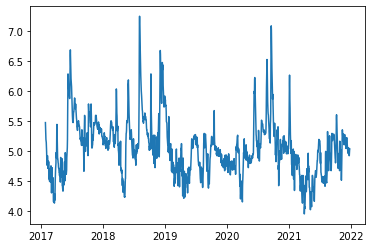

In [8]:
plt.plot(df2)

In [ ]:
#Determine if datase is stationary
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df2)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df2)


trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

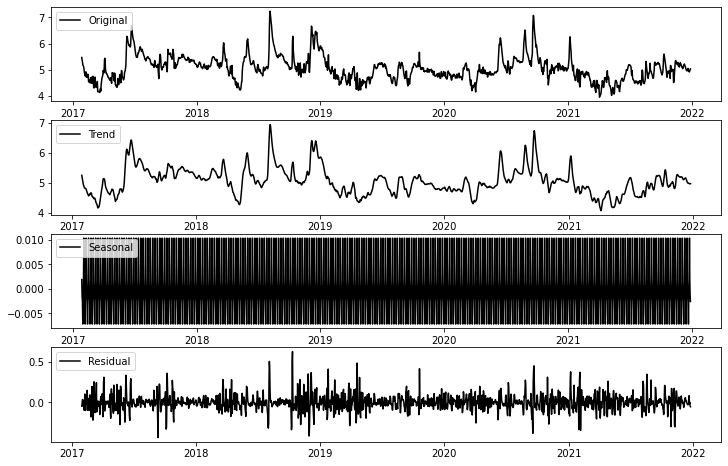

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df2, label='Original', color='k')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='k')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='k')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='k')
plt.legend(loc='upper left')
plt.show()

In [20]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df2, start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-1499.926, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1322.563, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-2014.186, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1477.718, Time=0.40 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-2186.552, Time=1.34 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-2281.384, Time=2.48 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-2357.667, Time=5.19 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-2411.032, Time=9.68 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=56.16 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=28.58 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=-2249.200, Time=7.34 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=-2444.681, Time=13.47 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-2388.420, Time=7.26 sec
 ARIMA(2,1,0)(5,1,1)

In [21]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1795
Model:             SARIMAX(2, 1, 0)x(5, 1, 0, 12)   Log Likelihood                1230.341
Date:                            Thu, 13 Jan 2022   AIC                          -2444.681
Time:                                    19:29:46   BIC                          -2400.797
Sample:                                         0   HQIC                         -2428.474
                                           - 1795                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3382      0.017     20.019      0.000       0.305       0.371
ar.L2         -0.1409      0.018   

In [22]:
size = int(len(df2) * 0.66)
X_train, X_test = df2[0:size], df2[size:len(df2)]
X_train

2017-01-27 15:51:00+00:00    5.47
2017-01-28 15:51:00+00:00    5.37
2017-01-29 15:51:00+00:00    5.31
2017-01-30 15:51:00+00:00    5.19
2017-01-31 15:51:00+00:00    5.16
                             ... 
2020-04-20 15:51:00+00:00    5.00
2020-04-21 15:51:00+00:00    4.88
2020-04-22 15:51:00+00:00    4.85
2020-04-23 15:51:00+00:00    5.02
2020-04-24 15:51:00+00:00    5.10
Freq: D, Name: Gage_Height_ft, Length: 1184, dtype: float64

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train,  
                order = (2, 1, 0),  
                seasonal_order =(5, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Gage_Height_ft   No. Observations:                 1184
Model:             SARIMAX(2, 1, 0)x(5, 1, 0, 12)   Log Likelihood                 829.542
Date:                            Thu, 13 Jan 2022   AIC                          -1643.085
Time:                                    19:22:51   BIC                          -1602.560
Sample:                                01-27-2017   HQIC                         -1627.801
                                     - 04-24-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3454      0.019     17.815      0.000       0.307       0.383
ar.L2         -0.1773      0.021     -8.396      0.000      -0.219      -0.136
ar.S.L12      -0.7995      0.027    -29.311      0.000      -0.853      -0.746
ar.S.L24      -0.6166      0.033    -18.655      0.000      -0.681      -0.552
ar.S.L36      -0.4897      0.036    -13.500      0.000      -0.561      -0.419
ar.S.L48      -0.3604      0.035    -10.384      0.000      -0.428      -0.292
ar.S.L60      -0.1821      0.026     -6.962      0.000      -0.233      -0.131
sigma2         0.0140      0.000     45.302      0.000       0.013       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1478.85
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.45
Prob(H) (two-sided):                  0.14   Kurtosis:                         8.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

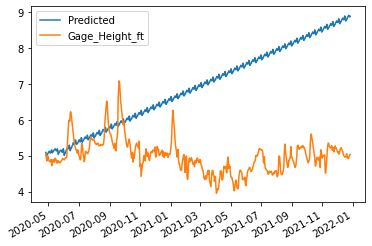

In [23]:
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#Prediction
start_index = len(X_train)
end_index = len(df2)-1
prediction = result.predict(start_index, end_index).rename('Predicted ') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test.plot(legend = True) 


